# Rethinking Statistics course in pymc3 - Week 1

Lecture 1: The Golem of Prague

- [Video](https://www.youtube.com/watch?v=4WVelCswXo4)
- [Slides](https://speakerdeck.com/rmcelreath/l01-statistical-rethinking-winter-2019)

Lecture 2: Garden of Forking Data

- [Video](https://www.youtube.com/watch?v=XoVtOAN0htU)
- [Slides](https://speakerdeck.com/rmcelreath/l02-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week01.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week01_solutions.pdf) for the exercises of the week.

In [122]:
import numpy as np
import pandas as pd
import pymc3 as pm
from random import choices
from scipy import stats
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

## Garden of Forking Data Example

Example for page 27 of book on possible color combination of 4 marbles, given drawing two blue and one white marble.

In [25]:
# vector of 5 possibilities
ways = [0, 3, 8, 9 , 0] # [all white, 1 blue 3 white, 2 blue 2 white, 3 blue 1 white, all blue]
prob = ways/np.sum(ways)

for i in zip(ways, prob):
    print('Ways: ', i[0], 'Probability: ', i[1])

Ways:  0 Probability:  0.0
Ways:  3 Probability:  0.15
Ways:  8 Probability:  0.4
Ways:  9 Probability:  0.45
Ways:  0 Probability:  0.0


## Short Intro

_In this short intro I just play around a bit with the concepts of prior and posterior. I calculate manually both for the very simple globe tossing example mentioned in the lecture. You can jump to the actual homework going to the next section._

In [3]:
n=9 # n trials
p=0.5 # probability of water or land event
k=6 # k successes

_How to generate binomials with `numpy` or `scipy`:_

In [4]:
np.random.binomial(1, p, n)

array([1, 1, 0, 1, 1, 1, 0, 1, 0])

In [5]:
stats.binom.rvs(1, p, size=n)

array([1, 1, 1, 0, 0, 0, 1, 0, 0])

_Density function of a binomial:_

In [7]:
round(stats.binom.pmf(k, n, p), 2) # probability mass function

0.16

## Grid approximation posterior estimation 
_Example:_ Page 40 of book

Steps for grid approximation:
1. Define the grid. Decide how manuy points to use in estimating the posterior and make a list parameter values.
2. Compute the value of the prior at each parameter value on grid.
3. Compute the likelihood of each parameter value.
4. Compute the unstandardized posterior at each parameter value by multiplying prior by likelihood
5. Standardize the posterior by dividing each value by the sum of all values

In [30]:
# 1. define grid
p_grid = np.linspace(0,1,101)
# 2. define prior
prob_p = np.ones(101) # all 1s
# 3. likelihood
prob_data = stats.binom.pmf(k, n, p=p_grid)
# 4. Compute unstadardized posterior (prior x likelihood)
posterior = prob_data * prob_p
# 5. Standardize the posterior
posterior = posterior / sum(posterior) # normalizing the posterior

Important that the posterior shoudl sum to 1.

In [35]:
print('First 3 obs of posterior calculation: ', posterior[:3])
print('Sum of posterior should sum to 1: ', sum(posterior))

First 3 obs of posterior calculation:  [0.00000000e+00 8.15051103e-12 5.05984784e-10]
Sum of posterior should sum to 1:  1.0000000000000002


_Looks good. Plotting the posterior:_

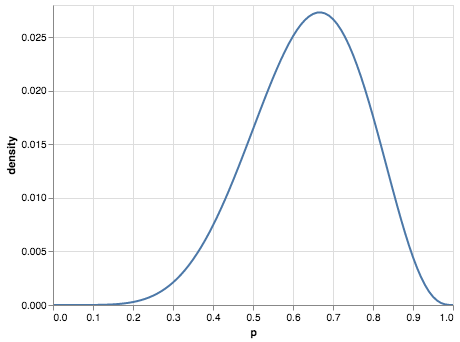

In [36]:
aux = pd.DataFrame(posterior).reset_index().rename({0:'prob'}, axis=1)
aux['p'] = aux['index']/100

alt.Chart(aux)\
   .mark_line()\
   .encode(
        x=alt.X('p', title='p'),
        y=alt.Y('prob', title='density')
          )

_Nice! Let's sample the posterior we just got:_

In [29]:
samples = pd.DataFrame(np.random.choice(p_grid, 5000, p=posterior))\
            .reset_index()\
            .rename({0:'prob'}, axis=1)

samples.head(10) # just to see how it looks

,index,prob
0,0,0.74
1,1,0.42
2,2,0.66
3,3,0.68
4,4,0.72
5,5,0.57
6,6,0.65
7,7,0.58
8,8,0.39
9,9,0.63


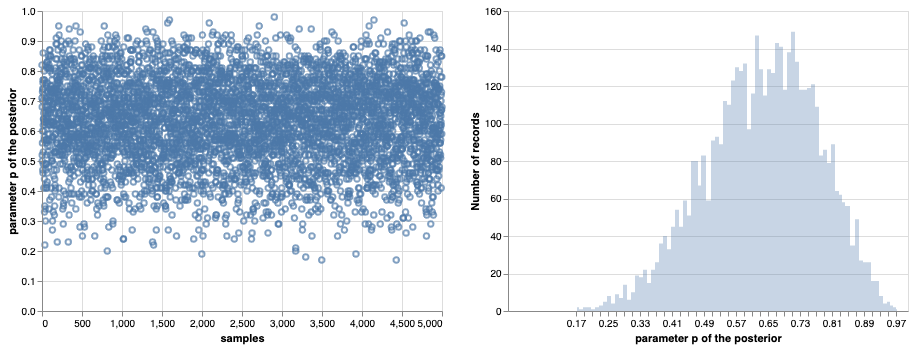

In [25]:
plot_1 = alt.Chart(samples)\
   .mark_point()\
   .encode(
        x=alt.X('index', title='samples'),
        y=alt.Y('prob', title='parameter p of the posterior')
          )

plot_2 = alt.Chart(samples).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('prob:Q', bin=alt.Bin(maxbins=200),scale=alt.Scale(domain=(0, 1)), title='parameter p of the posterior'),
    alt.Y('count()', stack=None, title='Number of records')
)

alt.hconcat(plot_1, plot_2)

_You can think of the first plot as a bird view of the second one (shifted 90 degrees). Let's calculate the credible intervals._

_1. Percentile Intervals_

_Option 1, `numpy`_

In [26]:
round(np.percentile(np.array(samples.prob), 2.5),2), round(np.percentile(np.array(samples.prob), 97.5),2)

(0.34, 0.88)

_Option 2, `pymc3`_

In [42]:
pm.stats.quantiles(np.array(samples.prob), qlist=[2.5, 97.5])

{2.5: 0.3, 97.5: 0.76}

_Both libraries produce identical results (good sign! jeje)_

_2. Highest Posterior Density Interval (HPDI)_

In [45]:
hpd = pm.stats.hpd(np.array(samples.prob), alpha=0.1)
hpd

array([0.33, 0.71])

_The HPDI leaves the `alpha` percentage of the distribution out, let's check it!_

In [46]:
(np.count_nonzero(np.array(samples.prob)<hpd[0])\
+ np.count_nonzero(np.array(samples.prob)>hpd[1]))\
/ len(np.array(samples.prob))

0.0982

_Correct! : D Let's start with the actual homework_

# Markov-Chain Monte Carlo (MCMC) Posterior Estimation

MCMC estimate of globe problem for  page 45.

In [139]:
# number of samples 
n = 10000
# empty list of probabilties
p = [None] * n
# initial probability value
p[0] = 0.5
# number of water
w = 6
# number of lad
l = 3

MCMC estimator

In [140]:
for i in range(1, n):
    p_new = np.random.normal(p[i-1], 0.1, 1)
    if p_new < 0:
        p_new = np.abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(w, w+l, p[i-1])
    q1 = stats.binom.pmf(w, w+l, p_new)
    if np.random.uniform(low=0.0, high=1.0, size=None) < q1/q0:
        p[i] = p_new[0]
    else:
        p[i] = p[i-1]

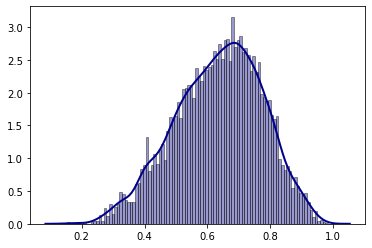

In [142]:
# Density Plot and Histogram of mcmc probabilities
ax = sns.distplot(p, hist=True, kde=True, 
                  bins=int(1000/10), color = 'darkblue', 
                  hist_kws={'edgecolor':'black'},
                  kde_kws={'linewidth': 2})


## Exercise 1

>Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

Really all you need is to modify the grid approximation code in Chapter 3 (_there are constant references to the book that I will keep just in case you guys want to check them out_). If you replace 6 with 8 and 9 with 15, it'll work:

In [206]:
n = 15 # 15 tosses/trials
k = 8 # 8 water/success

In [207]:
# define grid
p_grid = np.linspace(0,1,101)
prob_p = np.ones(101)
prob_data = stats.binom.pmf(k, n, p=p_grid)
posterior1 = prob_data * prob_p
posterior1 = posterior1 / sum(posterior1)

In [208]:
samples = pd.DataFrame(np.random.choice(p_grid, 5000, p=posterior1))\
            .reset_index()\
            .rename({0:'prob'}, axis=1)

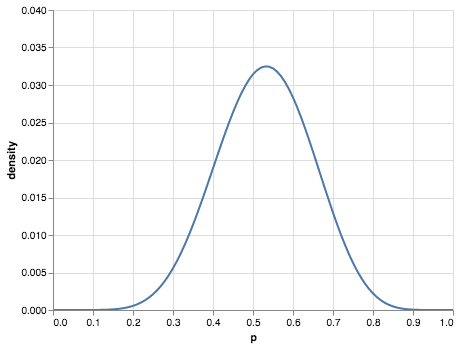

In [209]:
aux = pd.DataFrame(posterior1).reset_index().rename({0:'prob'}, axis=1)
aux['p'] = aux['index']/100

alt.Chart(aux)\
   .mark_line()\
   .encode(
        x=alt.X('p', title='p'),
        y=alt.Y('prob', title='density')
          )

The posterior mean should be about 0.53 and the 99% percentile interval from 0.24 to 0.81.

In [210]:
print('Mean of posterior: ', round(np.mean(samples.prob),2))

Mean of posterior:  0.53


In [211]:
print('0.5 and 99.5% quantiles: ', pm.stats.quantiles(np.array(samples.prob), qlist=[0.5, 99.5]))

0.5 and 99.5% quantiles:  {0.5: 0.24, 99.5: 0.81}


## Exercise 2

>Start over in 1, but now use a prior that is zero below $p = 0.5$ and a constant above $p = 0.5$. This corresponds to prior information that a majority of the Earth's surface is water. What difference does the better prior make? If it helps, compare posterior distributions (using both priors) to the true value $p = 0.7$.

Modifying only the prior:

In [212]:
p_grid = np.linspace(0,1,101) # grid
prob_p = np.concatenate((np.zeros(50), np.full(51,0.5))) # 0's below p = 0.5 and constant 1 above 0.5
prob_data = stats.binom.pmf(k, n, p=p_grid)
posterior2 = prob_data * prob_p
posterior2 = posterior2 / sum(posterior2)

In [213]:
samples = pd.DataFrame(np.random.choice(p_grid, 5000, p=posterior2))\
            .reset_index()\
            .rename({0:'prob'}, axis=1)

The posterior mean should be about 0.61 and the 99% interval 0.50 to 0.82. This prior yields a posterior with more mass around the true value of 0.7.

In [214]:
print('Posterior mean: ', round(np.mean(samples.prob),2))

Posterior mean:  0.6


In [215]:
pm.stats.quantiles(np.array(samples.prob), qlist=[0.5, 99.5])

{0.5: 0.5, 99.5: 0.8200000000000001}

This is probably easier to see in a plot:

In [216]:
# some data wrangling to prepate the plot
aux = pd.DataFrame(posterior1).reset_index().rename({0:'prob'}, axis=1)
aux['p'] = aux['index']/100
aux['posterior'] = 'posterior1'

aux2 = pd.DataFrame(posterior2).reset_index().rename({0:'prob'}, axis=1)
aux2['p'] = aux2['index']/100
aux2['posterior'] = 'posterior2'

aux = pd.concat([aux, aux2], axis=0)

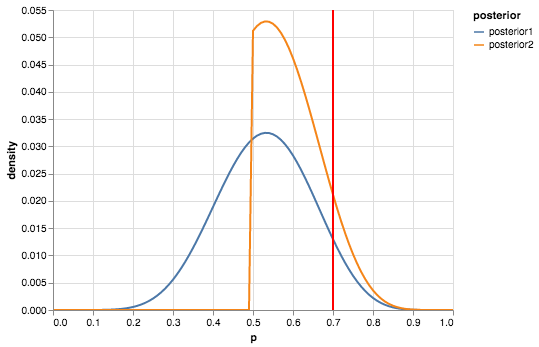

In [217]:
plot_posteriors = alt.Chart(aux)\
   .mark_line()\
   .encode(
        x=alt.X('p', title='p'),
        y=alt.Y('prob', title='density'),
        color = 'posterior'
          )

rule = alt.Chart(aux).mark_rule(color='red')\
    .encode(
    x='a:Q',
    size=alt.value(2)
           )

(plot_posteriors + rule).transform_calculate(a="0.7")

With the impossible values less than 0.5 ruled out, the second model piles up more plausibility on the higher values near the true value. The data are
still misleading it to think that values just above 0.5 are the most plausible. But the posterior mean of 0.63 is much better than 0.53 from the previous
problem.

Informative priors, when based on real scientific information, help. Here, the informative prior helps because there isn't much data. That is common in a lot of fields, ranging from astronomy to paleontology

## Exercise 3

>This problem is more open-ended than the others. Feel free to collaborate on the solution. Suppose you want to estimate the Earth's proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this? I won't require a precise answer. I'm honestly more interested in your approach.

One way to approach this problem is to try a range of sample sizes and to plot the interval width of each. Here's some code to compute the posterior and get the interval width.

There are other ways to compute the interval width. But the above (_below jeje_) is closest to the code in the book. Now since we want to do this for different values
of $N$, it's nice to make this into a function (_I just did a simple loop_).

Now if you enter f(20), you get an interval width for 20 globe tosses.
Now notice that the interval width varies across simulations. Try f(20) a few times to see what I mean. But as you increase N, this variation shrinks rapidly. This is because as the sample size increases, the differences between samples shrink. So if you ignore the sample to sample variation in interval width, that's okay in this example. But in the code below, I'll account for it. Now we need to run simulations across a bunch of different sample size to find where the interval shrinks to 0.05 in width.

In [220]:
p_grid

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [219]:
np.random.choice(p_grid, 10, p=posterior3)

array([0.691, 0.708, 0.7  , 0.694, 0.706, 0.707, 0.704, 0.703, 0.713,
       0.693])

In [218]:
p=0.7 # prior belief 
for n in [20, 50, 100, 200, 500, 1000, 2000, 3000, 5000]:
    k=sum(np.random.binomial(1, p, n))
    p_grid = np.linspace(0,1,1001)
    prob_p = np.ones(1001)
    prob_data = stats.binom.pmf(k, n, p=p_grid)
    posterior3 = prob_data * prob_p
    posterior3 = posterior3 / sum(posterior3)
    samples = pd.DataFrame(np.random.choice(p_grid, 5000, p=posterior3))\
                .reset_index()\
                .rename({0:'prob'}, axis=1)
    print(f'Distribution size: {n}, Mean: {round(np.mean(samples.prob),2)}, PI0.5&99.5: {pm.stats.quantiles(np.array(samples.prob), qlist=[0.5, 99.5])}')

Distribution size: 20, Mean: 0.59, PI0.5&99.5: {0.5: 0.325, 99.5: 0.8290000000000001}
Distribution size: 50, Mean: 0.6, PI0.5&99.5: {0.5: 0.417, 99.5: 0.757}
Distribution size: 100, Mean: 0.65, PI0.5&99.5: {0.5: 0.52, 99.5: 0.763}
Distribution size: 200, Mean: 0.73, PI0.5&99.5: {0.5: 0.642, 99.5: 0.803}
Distribution size: 500, Mean: 0.69, PI0.5&99.5: {0.5: 0.633, 99.5: 0.74}
Distribution size: 1000, Mean: 0.68, PI0.5&99.5: {0.5: 0.644, 99.5: 0.72}
Distribution size: 2000, Mean: 0.7, PI0.5&99.5: {0.5: 0.676, 99.5: 0.727}
Distribution size: 3000, Mean: 0.7, PI0.5&99.5: {0.5: 0.677, 99.5: 0.719}
Distribution size: 5000, Mean: 0.7, PI0.5&99.5: {0.5: 0.684, 99.5: 0.718}


Looks like we need more than 2000 tosses of the globe to get the interval to be that precise. The above is a general feature of learning from data: The greatest returns on learning come early on. Each additional observation contributes less and less. So it takes very much effort to progressively reduce our uncertainty. So if your application requires a very precise estimate, be prepared to collect a lot of data. Or to change your approach.